In [4]:
import imagej
ij_local_installation=r'C:\Fiji.app'
ij = imagej.init(ij_local_installation,headless=False)
ij.ui().showUI()

In [5]:
import matplotlib.pyplot as plt

In [6]:
#using python based sdt reader for support for compressed and simulated datasets
import sdtfile as sdt
test_sdtfile=sdt.SdtFile(r'../test_files/cells.sdt')
test_data=test_sdtfile.data[0].transpose(2,1,0)

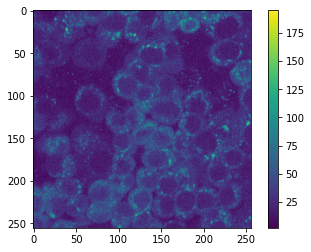

In [7]:
plt.imshow(test_data.sum(0))
plt.colorbar()

In [8]:
t_resolution = (test_sdtfile.times[0][1]-test_sdtfile.times[0][0]) * 10**9 # working in nanoseconds
print(t_resolution,' ns')


0.04886091184430619  ns


## 1. Using pyimageJ and fit without ij-window

In [9]:
%%time
FitParams = imagej.sj.jimport('flimlib.flimj.FitParams')
fitParams = FitParams()
fitParams.transMap = ij.py.to_java(test_data)
fitParams.xInc = t_resolution
fitParams.ltAxis = 2
fitResults = ij.op().run("flim.fitRLD",fitParams)

Wall time: 767 ms


In [10]:
paramMap = ij.py.from_java(fitResults.paramMap)

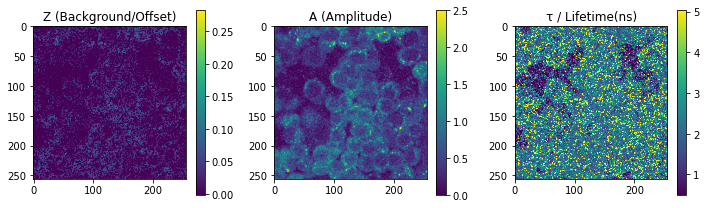

In [11]:
plt.figure(figsize=[10,3])

plt.subplot(131)
plt.imshow(paramMap[0],vmin=paramMap[0].mean())
plt.colorbar()
plt.title('Z (Background/Offset)')

plt.subplot(132)
plt.imshow(paramMap[1],vmax=paramMap[1].mean()*5)
plt.colorbar()
plt.title('A (Amplitude)')

plt.subplot(133)
plt.imshow(paramMap[2],vmax=paramMap[2].mean()*2,vmin=0.5)
plt.colorbar()
plt.title('τ / Lifetime(ns)')

plt.tight_layout()

# 2. Using a groovy script to fit the file in imagej

In [12]:
#see the data in the imagej GUI
ij.ui().show('test_data.sdt',ij.py.to_java(test_data))

In [13]:
%%time
# Running a groovy script to fit the open file using flim.fitRLD

ij.script().run('macro.groovy',
"""
# @ImageJ ij
# @ImgPlus img

op = ij.op()

import flimlib.flimj.FitParams
param = new FitParams()
param.transMap = img;

param.xInc= """+str(t_resolution)+"""
param.ltAxis = 2

rldRslt = op.run("flim.fitRLD", param)

rldRslt.paramMap
""" , True).get();

Wall time: 1.31 s


<java object 'org.scijava.script.ScriptModule'>

In [14]:
WindowManager = imagej.sj.jimport('ij.WindowManager')
rld_result = WindowManager.getCurrentImage()
paramMap = ij.py.from_java(rld_result)

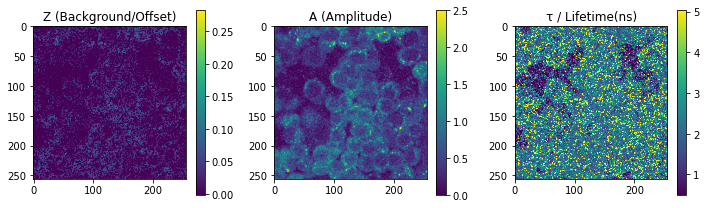

In [15]:
# Show the outputs

plt.figure(figsize=[10,3])

plt.subplot(131)
plt.imshow(paramMap[0],vmin=paramMap[0].mean())
plt.colorbar()
plt.title('Z (Background/Offset)')

plt.subplot(132)
plt.imshow(paramMap[1],vmax=paramMap[1].mean()*5)
plt.colorbar()
plt.title('A (Amplitude)')

plt.subplot(133)
plt.imshow(paramMap[2],vmax=paramMap[2].mean()*2,vmin=0.5)
plt.colorbar()
plt.title('τ / Lifetime(ns)')

plt.tight_layout()

# shutdown imagej instance

In [16]:
ij.dispose()